Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Using 505 files for validation.
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of training batches: 64
Number of validation batches: 16
train_dist: {'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
val_dist: {'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
overall_dist: {'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


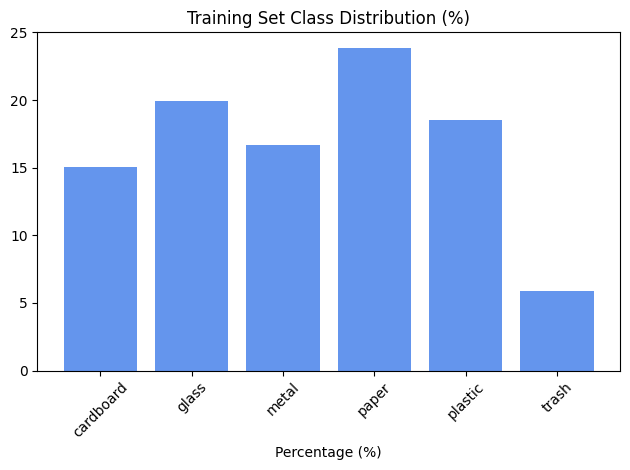

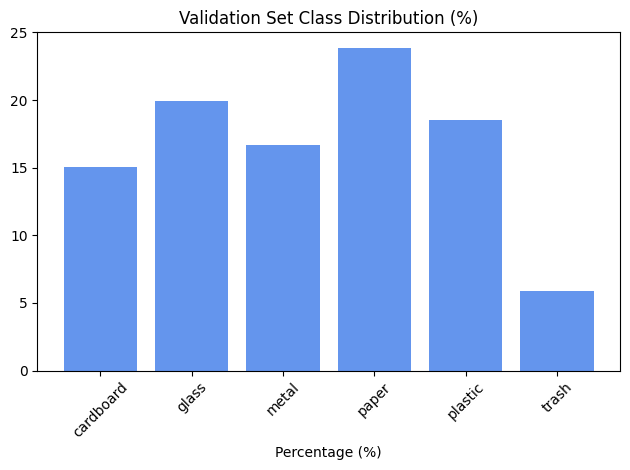

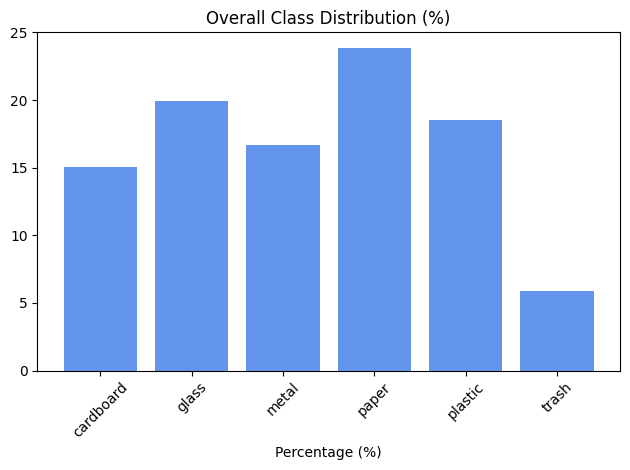

Class weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


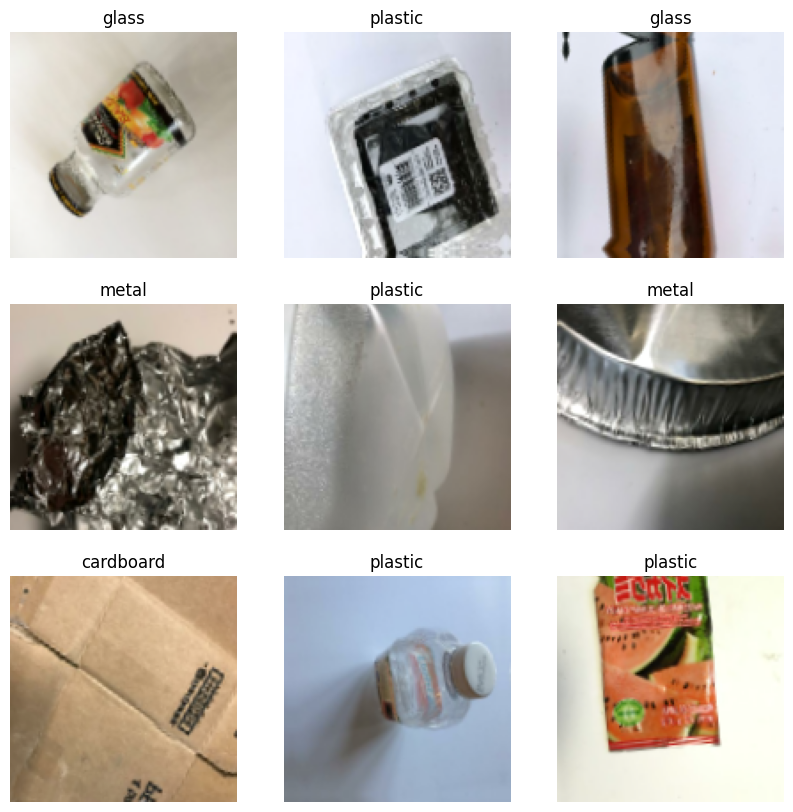

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset
dataset_dir = '/content/drive/MyDrive/Dataset'

# Load and preprocess the dataset
import tensorflow as tf

# Unpack the training and validation datasets directly
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)
print("Number of training batches:", train_ds.cardinality().numpy())
print("Number of validation batches:", val_ds.cardinality().numpy())

# Optimize dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Count class distribution
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    for _, labels in dataset.unbatch():
        label = labels.numpy()
        counts[class_names[label]] += 1
        total += 1
    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

# Calculate distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in train_dist}

# Print distributions
print("train_dist:", train_dist)
print("val_dist:", val_dist)
print("overall_dist:", overall_dist)

# Simple bar plot function
def simple_bar_plot_dist(title):
    plt.bar(class_names, list(overall_dist.values()), color='cornflowerblue')
    plt.title(title)
    plt.xlabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize distributions
import matplotlib.pyplot as plt

simple_bar_plot_dist('Training Set Class Distribution (%)')
simple_bar_plot_dist('Validation Set Class Distribution (%)')
simple_bar_plot_dist('Overall Class Distribution (%)')

# Compute class weights
class_counts = {i: 0 for i in range(len(class_names))}
for _, labels in train_ds.unbatch():
    label = labels.numpy()
    class_counts[label] += 1

total_samples = sum(class_counts.values())
n_classes = len(class_names)
class_weights = {i: (total_samples / (n_classes * count)) for i, count in class_counts.items()}

# Create dictionary mapping class index to weight
class_weight_dict = {i: w for i, w in enumerate(class_weights.values())}
print("Class weights:", class_weight_dict)

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Apply data augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

# Optional: Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])  # Use class_names with numpy label
        plt.axis("off")
plt.show()

Outcomes of Week 1
Mounted Google Drive and loaded dataset from /content/drive/MyDrive/DATA set.
Preprocessed data with 80/20 train/validation split, resized to (128, 128), and optimized with caching/prefetching.
Applied data augmentation (flip, rotation, zoom, contrast).
Analyzed class distribution, noting imbalance (e.g., trash at 5.42%, paper at 23.50%).
Visualized distributions with bar plots.